In [5]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  

</style>

In [6]:
import datetime
import matplotlib.pyplot as plt
import pyaurorax
import cartopy.crs

aurorax = pyaurorax.PyAuroraX()
at = aurorax.tools

### **Step 1: Download Raw Image Data**

In [7]:
# Download a minute of REGO data from several sites

dataset_name = "REGO_RAW"
start_dt = datetime.datetime(2018, 1, 14, 4, 48)
end_dt = start_dt
site_uid_list = ["resu", "talo", "gill", "fsmi", "fsim"]

data_download_objs = {}
for site_uid in site_uid_list:
    download_obj = aurorax.data.ucalgary.download(dataset_name, start_dt, end_dt, site_uid=site_uid)
    data_download_objs[site_uid] = download_obj

# Read in the data site-by-site, as we need this separation for mosaicing
data_list = []
for site_uid, download_obj in data_download_objs.items():
    data_list.append(aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames))

### **Step 2: Download Skymaps**

In [8]:
# Get list of all skymaps in previous two years up to date of interest for each site
skymap_download_objs = {}
for site_uid in site_uid_list:
    download_obj = aurorax.data.ucalgary.download(
        "REGO_SKYMAP_IDLSAV",
        start_dt.replace(year=start_dt.year - 2),
        start_dt,
        site_uid=site_uid,
    )
    skymap_download_objs[site_uid] = download_obj

# Read and store the last list index skymap for each site, as that is most recent to the date of interest
skymaps = []
for site_uid, download_obj in skymap_download_objs.items():

    skymap = aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames[-1])
    skymaps.append(skymap.data[0])

skymaps

[Skymap(project_uid=rego, site_uid=resu, imager_uid=rego-655, site_map_latitude=74.733002, site_map_longitude=265.100006, ...),
 Skymap(project_uid=rego, site_uid=talo, imager_uid=rego-657, site_map_latitude=69.540924, site_map_longitude=266.443268, ...),
 Skymap(project_uid=rego, site_uid=gill, imager_uid=rego-652, site_map_latitude=56.380001, site_map_longitude=265.359985, ...),
 Skymap(project_uid=rego, site_uid=fsmi, imager_uid=rego-656, site_map_latitude=60.026112, site_map_longitude=248.067062, ...),
 Skymap(project_uid=rego, site_uid=fsim, imager_uid=rego-654, site_map_latitude=61.759998, site_map_longitude=238.779999, ...)]

### **Step 3: Download Calibration_Files**

In [9]:
# Get list of all device uids up to date of interest for each site

device_uid_list = []
for data in data_list:
    print(data.metadata[0]["Imager unique ID"])
    device_uid_list.append(data.metadata[0]["Imager unique ID"][-3:])

print(device_uid_list)

rego-655
rego-657
rego-652
rego-656
rego-654
['655', '657', '652', '656', '654']


In [10]:
# Get list of all flatfield files in previous two years up to date of interest for each site
flatfield_download_objs = {}
for device_uid in device_uid_list:
    download_obj = aurorax.data.ucalgary.download(
        "REGO_CALIBRATION_FLATFIELD_IDLSAV",
        datetime.datetime(2000, 1, 1, 0, 0),
        start_dt,
        device_uid=device_uid,
    )
    flatfield_download_objs[device_uid] = download_obj

# Read and store the last list index flatfield for each site, as that is most recent to the date of interest
flatfields = []
for device_uid, download_obj in flatfield_download_objs.items():
    flatfield = aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames[-1])
    flatfields.append(flatfield.data[0])

for flatfield in flatfields:
    flatfield.pretty_print()

Calibration:
  dataset                       : Dataset(...)
  detector_uid                  : 15655
  filename                      : /home/darrenc/pyaurorax_data/REGO_CALIBRATION_FLATFIELD_IDLSAV/REGO_flatfield_15655_20141002-+_v01.sav
  flat_field_multiplier         : array(dims=(512, 512), dtype=>f8)
  generation_info               : CalibrationGenerationInfo(...)
  rayleighs_perdn_persecond     : None
  version                       : v01
Calibration:
  dataset                       : Dataset(...)
  detector_uid                  : 15657
  filename                      : /home/darrenc/pyaurorax_data/REGO_CALIBRATION_FLATFIELD_IDLSAV/REGO_flatfield_15657_20170804-+_v02.sav
  flat_field_multiplier         : array(dims=(512, 512), dtype=>f8)
  generation_info               : CalibrationGenerationInfo(...)
  rayleighs_perdn_persecond     : None
  version                       : v02
Calibration:
  dataset                       : Dataset(...)
  detector_uid                  : 15652
  file

In [11]:
# Get list of all Rayleighs files in previous two years up to date of interest for each site
rayleighs_download_objs = {}
for device_uid in device_uid_list:
    download_obj = aurorax.data.ucalgary.download(
        "REGO_CALIBRATION_RAYLEIGHS_IDLSAV",
        datetime.datetime(2014, 1, 1, 0, 0),
        start_dt,
        device_uid=device_uid,
    )
    rayleighs_download_objs[device_uid] = download_obj

# Read and store the last list index Rayleighs for each site, as that is most recent to the date of interest
rayleighs = []
for device_uid, download_obj in rayleighs_download_objs.items():

    rayleigh = aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames[-1])
    rayleighs.append(rayleigh.data[0])

for rayleigh in rayleighs:
    rayleigh.pretty_print()

Calibration:
  dataset                       : Dataset(...)
  detector_uid                  : 15655
  filename                      : /home/darrenc/pyaurorax_data/REGO_CALIBRATION_RAYLEIGHS_IDLSAV/REGO_Rayleighs_15655_20141002-+_v01.sav
  flat_field_multiplier         : None
  generation_info               : CalibrationGenerationInfo(...)
  rayleighs_perdn_persecond     : 10.399999618530273
  version                       : v01
Calibration:
  dataset                       : Dataset(...)
  detector_uid                  : 15657
  filename                      : /home/darrenc/pyaurorax_data/REGO_CALIBRATION_RAYLEIGHS_IDLSAV/REGO_Rayleighs_15657_20170804-+_v02.sav
  flat_field_multiplier         : None
  generation_info               : CalibrationGenerationInfo(...)
  rayleighs_perdn_persecond     : 15.909578462805896
  version                       : v02
Calibration:
  dataset                       : Dataset(...)
  detector_uid                  : 15652
  filename                      : /h

### **Step 4: Calibrate All Image Data**

In [12]:
# Calibrate first frame of each image and store in list for mosaic
for i, image_data in enumerate(data_list):

    # print(np.max(image_data.data))
    calibrated_image_data = at.calibration.rego(image_data.data, cal_flatfield=flatfields[i], cal_rayleighs=rayleighs[i])
    # replace the data in image_data with calibrated version
    # image_data.calibrated_data = calibrated_image_data
    data_list[i].calibrated_data = calibrated_image_data


In [13]:
data_list

[Data(data=array(dims=(512, 512, 20), dtype=uint16), timestamp=[20 datetimes], metadata=[20 dictionaries], problematic_files=[], calibrated_data=array(dims=(512, 512, 20), dtype=float32), dataset=Dataset(name=REGO_RAW, short_description='REGO All Sky Imagers 3-sec raw da...)),
 Data(data=array(dims=(512, 512, 20), dtype=uint16), timestamp=[20 datetimes], metadata=[20 dictionaries], problematic_files=[], calibrated_data=array(dims=(512, 512, 20), dtype=float32), dataset=Dataset(name=REGO_RAW, short_description='REGO All Sky Imagers 3-sec raw da...)),
 Data(data=array(dims=(512, 512, 20), dtype=uint16), timestamp=[20 datetimes], metadata=[20 dictionaries], problematic_files=[], calibrated_data=array(dims=(512, 512, 20), dtype=float32), dataset=Dataset(name=REGO_RAW, short_description='REGO All Sky Imagers 3-sec raw da...)),
 Data(data=array(dims=(512, 512, 20), dtype=uint16), timestamp=[20 datetimes], metadata=[20 dictionaries], problematic_files=[], calibrated_data=array(dims=(512, 512,

### **Step 5: Inspect Calibrated Data**

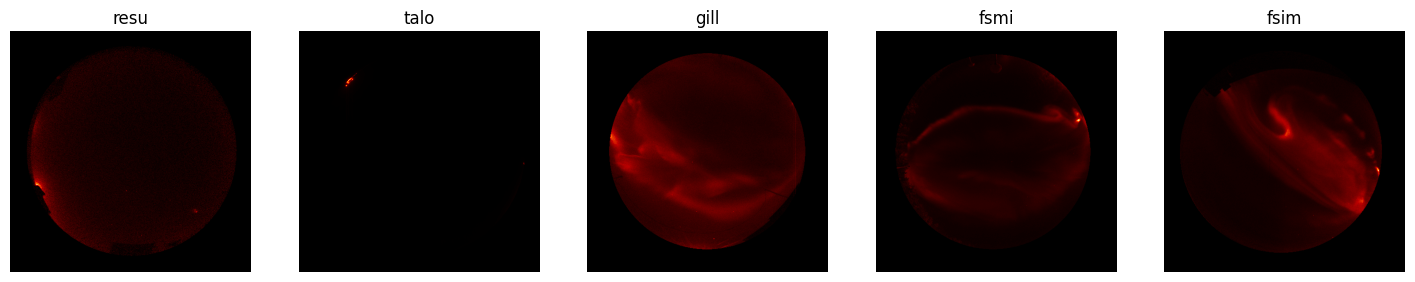

In [14]:
# Let's plot each site, and label with the min and max of the data, so we can get a good idea of how we should scale.
plt.figure(figsize=(18, 5))
for i, image_data in enumerate(data_list):
    plt.subplot(1, len(site_uid_list), i + 1)
    plt.title(site_uid_list[i])
    plt.imshow(image_data.calibrated_data[:, :, 0], cmap='gist_heat', origin='lower')
    plt.axis('off')

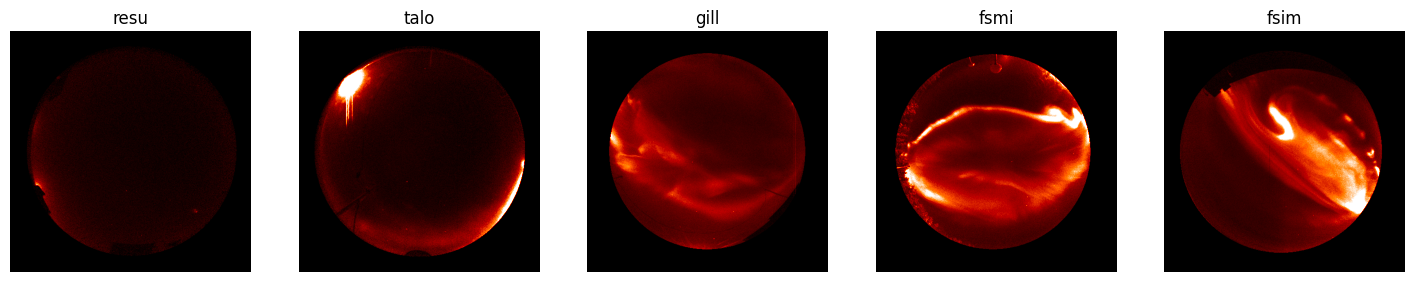

In [15]:
# Since we are working with absolute intensity data, ALL SITES MUST BE SCALED THE SAME, let's mess around with the scaling
scale_bounds = [0, 5000]

# Let's plot each site, and label with the min and max of the data, so we can get a good idea of how we should scale.
plt.figure(figsize=(18, 5))
for i, image_data in enumerate(data_list):
    plt.subplot(1, len(site_uid_list), i + 1)
    plt.title(site_uid_list[i])
    cal_data = at.scale_intensity(image_data.calibrated_data, min=scale_bounds[0], max=scale_bounds[1], top=255)
    plt.imshow(cal_data[:, :, 0], cmap='gist_heat', origin='lower')
    plt.axis('off')

### **Step 6: Generate the Mosaic**

In [16]:
# Prepare skymaps
prepped_skymap = at.mosaic.prep_skymaps(skymaps, 230, n_parallel=5)
prepped_skymap

Preparing skymaps:   0%|          | 0/5 [00:00<?, ?skymap/s]

MosaicSkymap(polyfill_lat=array(dims=(5, 262144), dtype=float64), polyfill_lon=array(dims=(5, 262144), dtype=float64), elevation=array(dims=(262144,), dtype=float32), site_uid_list=['resu', 'talo', 'gill', 'fsmi', 'fsim'])

In [17]:
# prepare the image data
prepped_images = at.mosaic.prep_images(data_list, data_attribute="calibrated_data")
prepped_images

MosaicData(images=Dict[5 sites of array(dims=(512, 512))], timestamps=[20 timestamps], site_uid_list=['resu', 'talo', 'gill', 'fsmi', 'fsim'])

In [18]:
# Define the intensity scales for each site... all the same, as we're working in Rayleighs
scale = {
    "resu": [0, 5000],
    "talo": [0, 5000],
    "gill": [0, 5000],
    "fsmi": [0, 5000],
    "fsim": [0, 5000],
}

# create projection
center_lat = -100.0
center_lon = 55.0
projection_obj = cartopy.crs.NearsidePerspective(central_longitude=center_lat, central_latitude=center_lon)

# create mosaic
frame_num = 0
mosaic = at.mosaic.create(prepped_images,
                          prepped_skymap,
                          frame_num,
                          projection_obj,
                          image_intensity_scales=scale,
                          colormap='gist_heat',
                          min_elevation=10)
print(mosaic)

Mosaic(polygon_data=PolyCollection(...), cartopy_projection=Projection(+proj=nsper +a=6378137.0 +lon_0=-100.0 +lat_0=55.0 +h=35785831 +x_0=0 +y_0=0 +units=m +no_defs +type=crs))


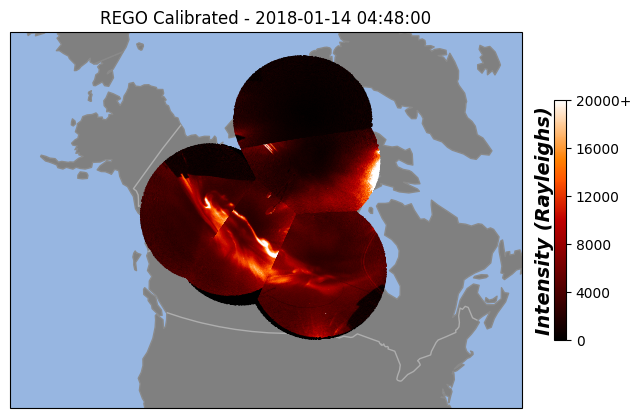

In [19]:
# plot mosaic
map_extent = [-145, -65, 33, 85]
mosaic.plot(map_extent, rayleighs=True, cbar_colormap='gist_heat', title="REGO Calibrated - %s" % (data_list[0].timestamp[0].strftime("%Y-%m-%d %H:%M:%S")))